In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%matplotlib notebook
%matplotlib inline

In [3]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/1d/bias')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations/fc_abc.yaml')

In [4]:
import sys
sys.path.append(ROOT)

In [5]:
import torch
import pickle
from utils.tools import load_pickle

from utils.tools import read_yaml, set_random_seeds
from utils.plot.abc_parameterizations.initializations import *
from utils.plot.abc_parameterizations.one_d_functions import *
from pytorch.configs.base import BaseConfig
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected import muP, ipllr, ipllr_bias, standard_fc_ip

In [6]:
from utils.plot.abc_parameterizations.one_d_functions import *

## Set variables

In [7]:
SEED = 42
N_SAMPLES = 100
N_TRAIN = 10
BASE_LR = 0.2

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)
base_config = ModelConfig(config_dict)

# modify config for this notebook
base_config.architecture['input_size'] = 1
base_config.architecture['output_size'] = 1
base_config.architecture['bias'] = False
base_config.activation.name = 'relu'
base_config.loss.name = 'mse'
base_config.optimizer.params['lr'] = BASE_LR

In [8]:
xs, ys = generate_1d_data(n_samples=10)

In [9]:
batch_xs = torch.unsqueeze(xs, 1)
batch_ys = torch.unsqueeze(ys, 1)

In [10]:
batches = [(batch_xs, batch_ys) for _ in range(3)]

## Define models

In [11]:
WIDTHS = [1024]
N_WARMUP_STEPS = 1  # 4
L = 4
N_TRIALS = 3  # 5
N_EPOCHS = 4000 # 6000

In [12]:
name_to_model_dict = {
    'muP': muP.FCmuP,
    #'IPLLR': ipllr.FcIPLLR,
    #'IPLLR-calibrate': ipllr.FcIPLLR,
    #'IPLLR-bias': ipllr_bias.FcIPLLRBias,
    #'IPLLR-bias-scale': ipllr_bias.FcIPLLRBias,
    'IP-non-centered': standard_fc_ip.StandardFCIP,
    'IP-non-centered-calib': standard_fc_ip.StandardFCIP
}

In [13]:
models_dict = dict()
for name, model in name_to_model_dict.items():
    models_dict[name] = dict()
    for width in WIDTHS:  # define models with different widths
        # first modify the base common config
        config = deepcopy(base_config)
        config.name = name
        config.architecture['width'] = width
        config.architecture['n_layers'] = L + 1
            
        if name == 'muP':
            config.optimizer.params['lr'] = BASE_LR
            config.scheduler = None
            models_dict[name][width] = [name_to_model_dict[name](config) for _ in range(N_TRIALS)]
            
        elif name == 'IP-non-centered':
            config.optimizer.params['lr'] = BASE_LR
            config.scheduler = None
            models_dict[name][width] = [name_to_model_dict[name](config) for _ in range(N_TRIALS)]
            
        elif name == 'IP-non-centered-calib':
            config.optimizer.params['lr'] = BASE_LR
            config.scheduler = None
            models_dict[name][width] = [name_to_model_dict[name](config) for _ in range(N_TRIALS)]

In [14]:
for model in models_dict['IP-non-centered-calib'][1024]:
    # set large base_lr for first step
    for param_group in model.optimizer.param_groups:
        param_group['lr'] = param_group['lr'] / model.base_lr

    fit_model(model, batch_xs, batch_ys, n_epochs=1)
    
    # reset base_lr for further steps
    for param_group in model.optimizer.param_groups:
        param_group['lr'] =  model.base_lr * param_group['lr']

### Set U and v to be the same for all models

In [15]:
for name in models_dict.keys():
    if name == 'IP-non-centered':
        for width in WIDTHS:
            for i in range(N_TRIALS):
                muP = models_dict['muP'][width][i]
                model = models_dict[name][width][i]
                with torch.no_grad():
                    model.copy_initial_params_from_model(muP, check_model=True)
                    model.initialize_params()

In [16]:
#for width in WIDTHS:
#    for ipllr in models_dict['IPLLR'][width]:
        # re-calibrate lr with new weights copied from muP
#        initial_base_lrs = ipllr.scheduler.calibrate_base_lr(ipllr, batches=batches, normalize_first=True)
#        ipllr.scheduler._set_param_group_lrs(initial_base_lrs)

        # scale lr of first layer by (d+1)
#        ipllr.scheduler.warm_lrs[0] = ipllr.scheduler.warm_lrs[0] * (ipllr.d + 1)

In [17]:
batch_xs = torch.unsqueeze(xs, 1)
batch_ys = torch.unsqueeze(ys, 1)
for name in models_dict.keys():
    if name != 'muP':
        for width in WIDTHS:
            for model in models_dict[name][width]:
                fit_model(model, batch_xs, batch_ys, n_epochs=N_EPOCHS)

#for name in ['IPLLR']:
#for name in ['muP']:
#    for width in WIDTHS:
#        for model in models_dict[name][width]:
#            fit_model(model, batch_xs, batch_ys, n_epochs=N_EPOCHS)

### muP

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


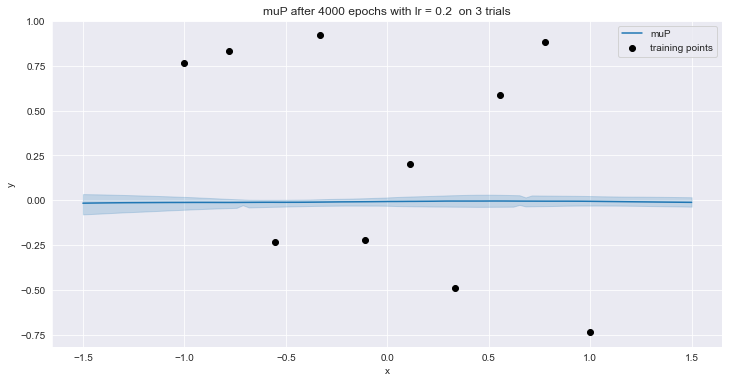

In [18]:
name = 'muP'
base_lr = models_dict[name][1024][0].base_lr
plt.figure(figsize=(12, 6))
plot_model(models_dict[name][1024], xs, ys, label=name, scatter=True, x_max=1.5)
# plt.ylim(-0.0001, 0.0001)
plt.title('muP after {} epochs with lr = {}  on {} trials'.format(N_EPOCHS, base_lr, N_TRIALS))
#plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trials_{}.png'.format(name, base_lr, N_EPOCHS, N_TRIALS)))
plt.show()

### IP non-centered

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


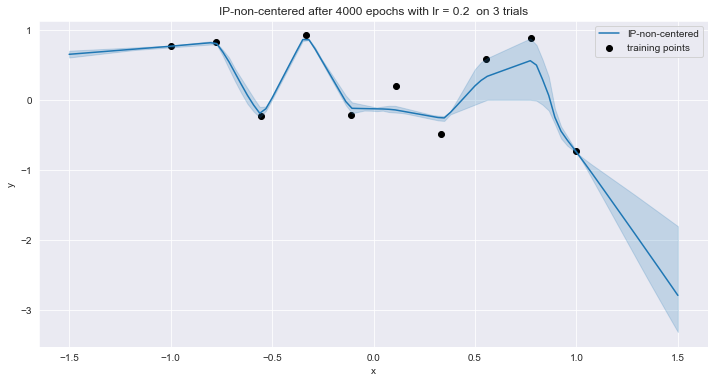

In [19]:
name = 'IP-non-centered'
base_lr = models_dict[name][1024][0].base_lr

plt.figure(figsize=(12, 6))
plot_model(models_dict[name][1024], xs, ys, label=name, scatter=True, x_max=1.5)
# plt.ylim(-0.0001, 0.0001)
plt.title('IP-non-centered after {} epochs with lr = {}  on {} trials'.format(N_EPOCHS, base_lr, N_TRIALS))
#plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trials_{}.png'.format(name, base_lr, N_EPOCHS, N_TRIALS)))

plt.show()

### IP non-centered calib

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


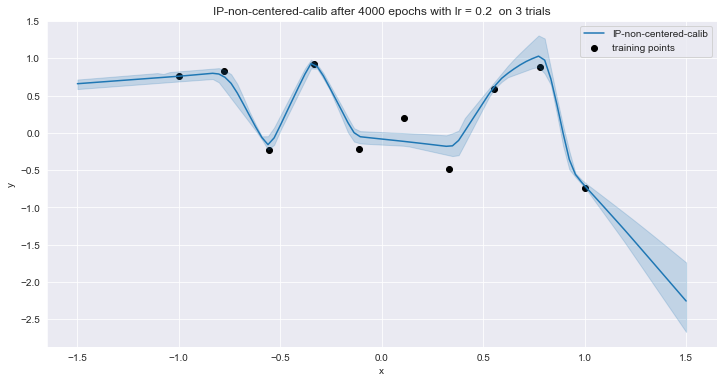

In [20]:
name = 'IP-non-centered-calib'
base_lr = models_dict[name][1024][0].base_lr

plt.figure(figsize=(12, 6))
plot_model(models_dict[name][1024], xs, ys, label=name, scatter=True, x_max=1.5)
# plt.ylim(-0.0001, 0.0001)
plt.title('IP-non-centered-calib after {} epochs with lr = {}  on {} trials'.format(N_EPOCHS, base_lr, N_TRIALS))
#plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trials_{}.png'.format(name, base_lr, N_EPOCHS, N_TRIALS)))

plt.show()